# A Empresa Cardio Catch Diseases ( CCD )

### Informações da base de dados

- Age: Idade em dias
- Height: Altura em centímetros
- Weight: Peso em quilogramas
- Gender: Gênero (1 - mulheres, 2 - homens)
- ap_hi: Pressão arterial sistólica (é aquela que marca a contração do músculo cardíaco, quando ele bombeia sangue para o corpo) 
         Normal: <130, Normal alta: 130-139, Hipertensão de grau 1: 140-159, Hipertensão de grau 2: ≥160

- ap_lo: Pressão arterial diastólica (é a do momento de repouso, em que os vasos permanecem abertos para o sangue passar)
         Normal: <85, Normal alta: 85-89, Hipertensão de grau 1: 90-99, Hipertensão de grau 2: ≥100

- Cholesterol: Colesterol (1 - normal, 2 - acima do normal, 3 - bem acima do normal)
- gluc: Glicose (1 - normal, 2 - acima do normal, 3 - bem acima do normal)
- smoke: Fumante (0 - não, 1 - sim)
- alco: Ingestão de álcool (0 - não, 1 - sim)
- active: Atividade física (0 - não, 1 - sim)
- cardio: Presença ou ausência de doença cardiovascular (0 - não, 1 - sim)

## - Objetivo: criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [3]:
sns.set_style('darkgrid')

In [4]:
dados = pd.read_csv("cardio_train.csv", sep = ";")

In [5]:
dados.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


A base de dados não possui valores faltantes.

### Análise inicial

#### - Coluna de identificação

In [7]:
len(np.unique(dados.id))

70000

Não temos identificações repetidas

#### - Variáveis categóricas

In [8]:
print(f"valores das variáveis:\ncholesterol:{np.unique(dados.cholesterol)},\ngluc: {np.unique(dados.gluc)},\n\
smoke: {np.unique(dados.smoke)},\nalco: {np.unique(dados.alco)},\nactive: {np.unique(dados.active)},\n\
cardio: {np.unique(dados.cardio)}\ngender: {np.unique(dados.gender)}")

valores das variáveis:
cholesterol:[1 2 3],
gluc: [1 2 3],
smoke: [0 1],
alco: [0 1],
active: [0 1],
cardio: [0 1]
gender: [1 2]


As variáveis categóricas não possuem valores fora do esperado.

#### - Variáveis quantitativas

In [9]:
dados['age_year'] = round(dados['age']/365)
print(f"As idades informadas estão entre {min(dados['age_year'])} e {max(dados['age_year'])} anos.")

As idades informadas estão entre 30.0 e 65.0 anos.


In [10]:
print(f'Peso mais baixo: {min(dados.weight)}, maior peso: {max(dados.weight)}')
print(f'Menor altura: {min(dados.height)}, maior altura: {max(dados.height)}')

Peso mais baixo: 10.0, maior peso: 200.0
Menor altura: 55, maior altura: 250


Para facilitar a utilização desses dados na predição o índice de massa corporal.

In [11]:
dados['imc'] = dados.weight/(dados.height/100)**2

In [12]:
print(f"Pressão arterial sistólica mais baixa {min(dados['ap_hi'])} e mais alta {max(dados['ap_hi'])}.")

Pressão arterial sistólica mais baixa -150 e mais alta 16020.


In [13]:
print(f"Pressão arterial diastólica mais baixa {min(dados['ap_lo'])} e mais alta {max(dados['ap_lo'])}.")

Pressão arterial diastólica mais baixa -70 e mais alta 11000.


Como temos alguns valores que parecem destoar da realidade, vamos criar categorizar as variáveis de forma que o classificador tenha sucesso na hora da predição.

In [14]:
dados.loc[(dados.ap_hi < 130), 'cat_aphi'] = 'normal'
dados.loc[(dados.ap_hi >= 130) & (dados.ap_hi < 140), 'cat_aphi'] = 'normal alto'
dados.loc[(dados.ap_hi >= 140) & (dados.ap_hi < 159), 'cat_aphi'] = 'Hipertensão de grau 1'
dados.loc[(dados.ap_hi >= 160), 'cat_aphi'] = 'Hipertensão de grau 2'

In [15]:
dados.loc[(dados.ap_lo < 85), 'cat_aplo'] = 'normal'
dados.loc[(dados.ap_lo >= 85) & (dados.ap_lo < 90), 'cat_aplo'] = 'normal alto'
dados.loc[(dados.ap_lo >= 90) & (dados.ap_lo < 99), 'cat_aplo'] = 'Hipertensão de grau 1'
dados.loc[(dados.ap_lo >= 100), 'cat_aplo'] = 'Hipertensão de grau 2'

In [16]:
dados.imc = pd.to_numeric(dados.imc)
dados.loc[(dados.imc < 16), 'cat_imc'] = 'subpeso severo'
dados.loc[(dados.imc >= 16) & (dados.imc < 20), 'cat_imc'] = 'subpeso'
dados.loc[(dados.imc >= 20) & (dados.imc < 25), 'cat_imc'] = 'normal'
dados.loc[(dados.imc >= 25) & (dados.imc < 30), 'cat_imc'] = 'sobrepeso'
dados.loc[(dados.imc >= 30) & (dados.imc < 40), 'cat_imc'] = 'obesidade'
dados.loc[(dados.imc >= 40), 'cat_imc'] = 'obesidade mórbida'

In [17]:
dados.loc[(dados.age_year >= 30) & (dados.age_year < 40), 'cat_age'] = '[30, 40)'
dados.loc[(dados.age_year >= 40) & (dados.age_year < 50), 'cat_age'] = '[40, 50)'
dados.loc[(dados.age_year >= 50) & (dados.age_year < 60), 'cat_age'] = '[50, 60)'
dados.loc[(dados.age_year >= 60) & (dados.age_year <= 65), 'cat_age'] = '[60, 65]'

In [18]:
dados.gender = dados.gender.replace([1, 2], ['M', 'H'])

In [19]:
dados.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,imc,cat_aphi,cat_aplo,cat_imc,cat_age
0,0,18393,H,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120,normal,normal,normal,"[50, 60)"
1,1,20228,M,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679,Hipertensão de grau 1,Hipertensão de grau 1,obesidade,"[50, 60)"
2,2,18857,M,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805,normal alto,normal,normal,"[50, 60)"
3,3,17623,H,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479,Hipertensão de grau 1,Hipertensão de grau 2,sobrepeso,"[40, 50)"
4,4,17474,M,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177,normal,normal,normal,"[40, 50)"


In [20]:
data_to_predict = dados[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'cat_aphi', 'cat_aplo', 'cat_imc', 'cat_age', 'active', 'cardio']]

## Análise Visual

In [21]:
data_to_predict.head()

,gender,cholesterol,gluc,smoke,alco,cat_aphi,cat_aplo,cat_imc,cat_age,active,cardio
0,H,1,1,0,0,normal,normal,normal,"[50, 60)",1,0
1,M,3,1,0,0,Hipertensão de grau 1,Hipertensão de grau 1,obesidade,"[50, 60)",1,1
2,M,3,1,0,0,normal alto,normal,normal,"[50, 60)",0,1
3,H,1,1,0,0,Hipertensão de grau 1,Hipertensão de grau 2,sobrepeso,"[40, 50)",1,1
4,M,1,1,0,0,normal,normal,normal,"[40, 50)",0,0


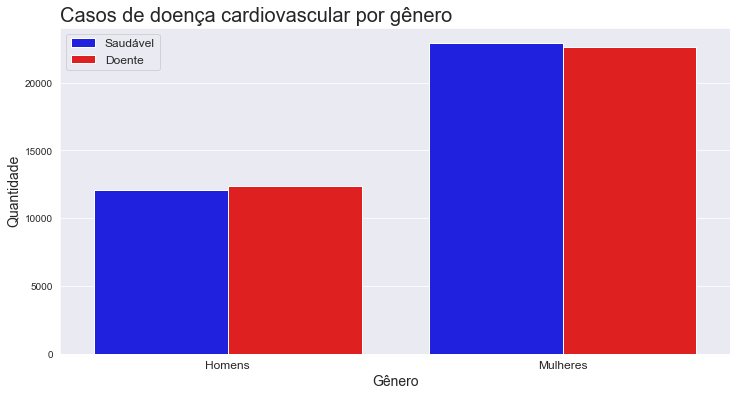

In [22]:
plt.figure(figsize = (12, 6))
genero = sns.countplot(x = 'gender', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
genero.set_title("Casos de doença cardiovascular por gênero", fontsize = 20, loc = 'left')
genero.set_xlabel("Gênero", fontsize = 14)
genero.set_ylabel("Quantidade", fontsize = 14)
genero.legend(['Saudável', 'Doente'], fontsize = 12)
genero.set_xticklabels(['Homens', 'Mulheres'], fontsize = 12)
genero = genero

A proporção de doença cardiovascular é muito semelhante entre homens e mulheres. 

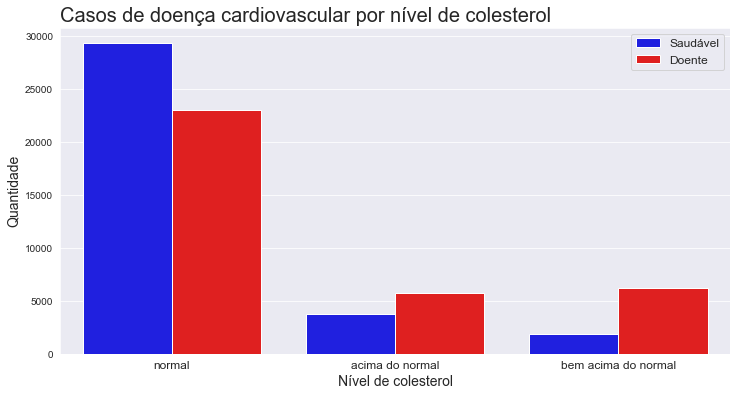

In [23]:
plt.figure(figsize = (12, 6))
col = sns.countplot(x = 'cholesterol', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
col.set_title("Casos de doença cardiovascular por nível de colesterol", fontsize = 20, loc = 'left')
col.set_xlabel("Nível de colesterol", fontsize = 14)
col.set_ylabel("Quantidade", fontsize = 14)
col.legend(['Saudável', 'Doente'], fontsize = 12)
col.set_xticklabels(['normal', 'acima do normal', 'bem acima do normal'], fontsize = 12)
col = col

Quanto maior o nível de colesterol maior a proporção de incidência de doença cardiovascular.

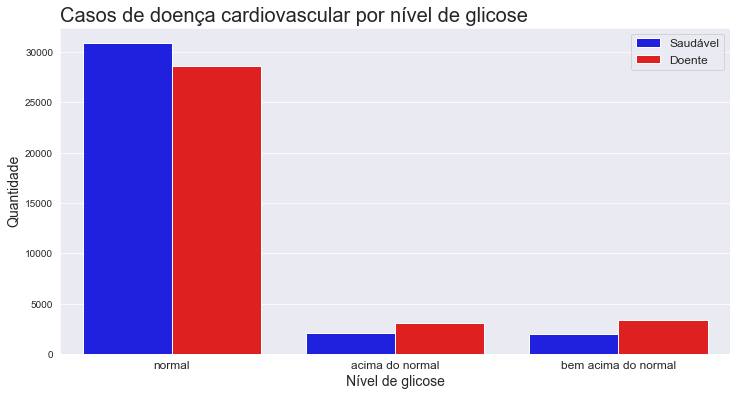

In [24]:
plt.figure(figsize = (12, 6))
gli = sns.countplot(x = 'gluc', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
gli.set_title("Casos de doença cardiovascular por nível de glicose", fontsize = 20, loc = 'left')
gli.set_xlabel("Nível de glicose", fontsize = 14)
gli.set_ylabel("Quantidade", fontsize = 14)
gli.legend(['Saudável', 'Doente'], fontsize = 12)
gli.set_xticklabels(['normal', 'acima do normal', 'bem acima do normal'], fontsize = 12)
gli = gli

A proporção de doença cardiovascular aumenta com o aumento do nível de glicose.

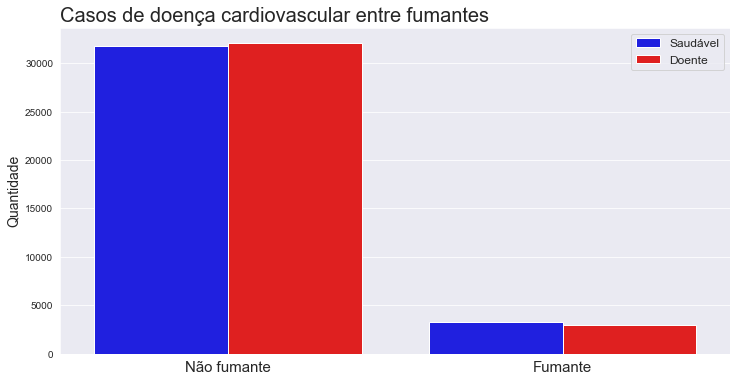

In [25]:
plt.figure(figsize = (12, 6))
fumo = sns.countplot(x = 'smoke', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
fumo.set_title("Casos de doença cardiovascular entre fumantes", fontsize = 20, loc = 'left')
fumo.set_xlabel("")
fumo.set_ylabel("Quantidade", fontsize = 14)
fumo.legend(['Saudável', 'Doente'], fontsize = 12)
fumo.set_xticklabels(['Não fumante', 'Fumante'], fontsize = 15)
fumo = fumo

A proporção de doença cardiovascular parece não ser afetada significativamente pelo consumo de cigarros.

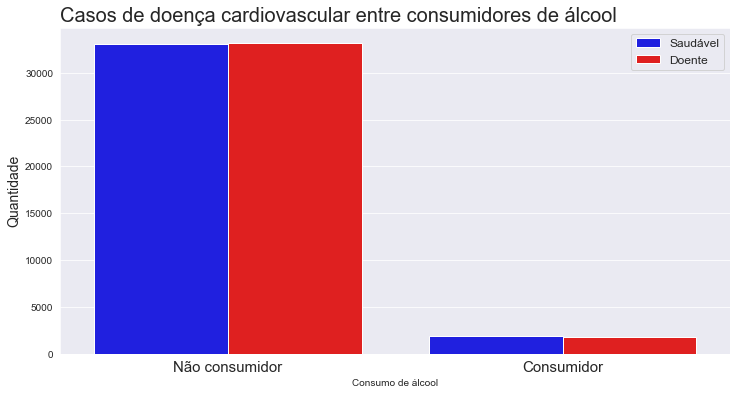

In [26]:
plt.figure(figsize = (12, 6))
alc = sns.countplot(x = 'alco', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
alc.set_title("Casos de doença cardiovascular entre consumidores de álcool", fontsize = 20, loc = 'left')
alc.set_xlabel("Consumo de álcool")
alc.set_ylabel("Quantidade", fontsize = 14)
alc.legend(['Saudável', 'Doente'], fontsize = 12)
alc.set_xticklabels(['Não consumidor', 'Consumidor'], fontsize = 15)
alc = alc

O consumo de álcool não influência na ocorrência de doença cardiovascular.

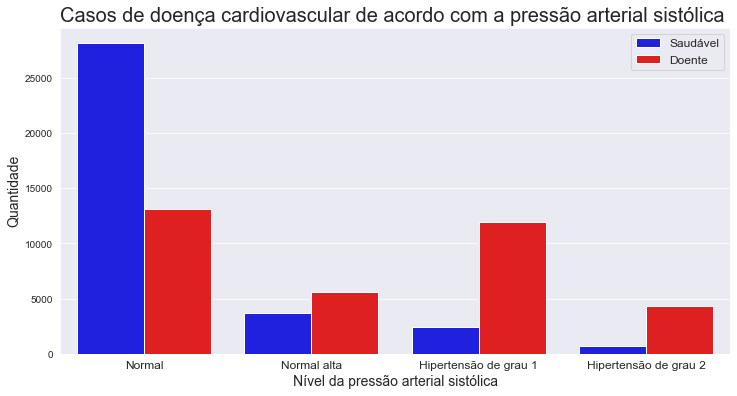

In [27]:
plt.figure(figsize = (12, 6))
sist = sns.countplot(x = 'cat_aphi', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                      order = ['normal', 'normal alto', 'Hipertensão de grau 1', 'Hipertensão de grau 2'])
sist.set_title("Casos de doença cardiovascular de acordo com a pressão arterial sistólica", fontsize = 20, loc = 'left')
sist.set_xlabel("Nível da pressão arterial sistólica", fontsize = 14)
sist.set_ylabel("Quantidade", fontsize = 14)
sist.legend(['Saudável', 'Doente'], fontsize = 12)
sist.set_xticklabels(['Normal', 'Normal alta', 'Hipertensão de grau 1', 'Hipertensão de grau 2'], fontsize = 12)
sist = sist

A proporção da doença aumenta significativamente com o aumento da pressão arterial sistólica. O nível de hipertensão de grau 1 parece ser o grau de pressão que mais afeta a causa da doença.

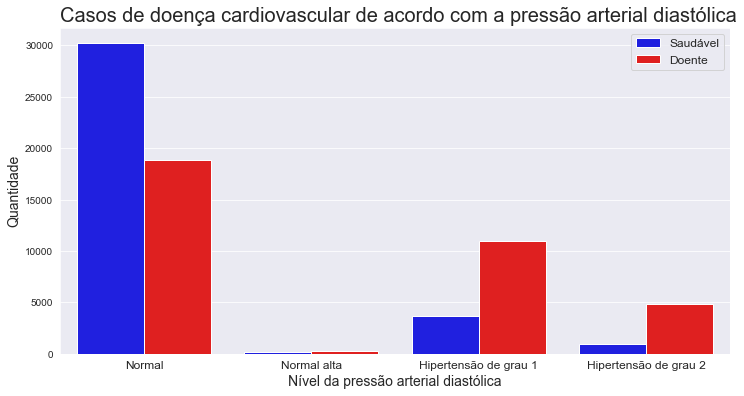

In [28]:
plt.figure(figsize = (12, 6))
dias = sns.countplot(x = 'cat_aplo', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                       order = ['normal', 'normal alto', 'Hipertensão de grau 1', 'Hipertensão de grau 2'])
dias.set_title("Casos de doença cardiovascular de acordo com a pressão arterial diastólica", fontsize = 20, loc = 'left')
dias.set_xlabel("Nível da pressão arterial diastólica", fontsize = 14)
dias.set_ylabel("Quantidade", fontsize = 14)
dias.legend(['Saudável', 'Doente'], fontsize = 12)
dias.set_xticklabels(['Normal', 'Normal alta', 'Hipertensão de grau 1', 'Hipertensão de grau 2'], fontsize = 12)
dias = dias

Assim como a pressão arterial sistólica, a pressão arterial diastélica também afeta a ocorrência de doença cardiovascular.

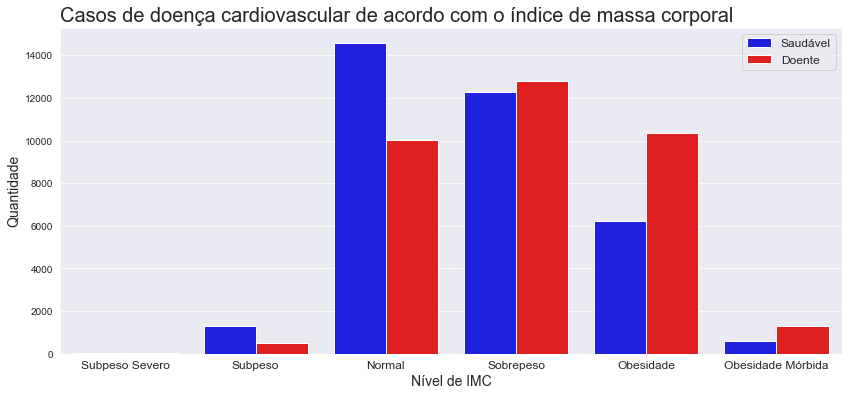

In [29]:
plt.figure(figsize = (14, 6))
imc = sns.countplot(x = 'cat_imc', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                      order = ['subpeso severo', 'subpeso', 'normal', 'sobrepeso', 'obesidade', 'obesidade mórbida'])
imc.set_title("Casos de doença cardiovascular de acordo com o índice de massa corporal", fontsize = 20, loc = 'left')
imc.set_xlabel("Nível de IMC", fontsize = 14)
imc.set_ylabel("Quantidade", fontsize = 14)
imc.legend(['Saudável', 'Doente'], fontsize = 12)
imc.set_xticklabels(['Subpeso Severo', 'Subpeso', 'Normal', 'Sobrepeso', 'Obesidade', 'Obesidade Mórbida'], fontsize = 12)
imc = imc

Aqui também é fácil perceber que o aumento do índice de massa corporal influencia na proporção da incidência de doença cardiovascular, principalmente no nível de obesidade.

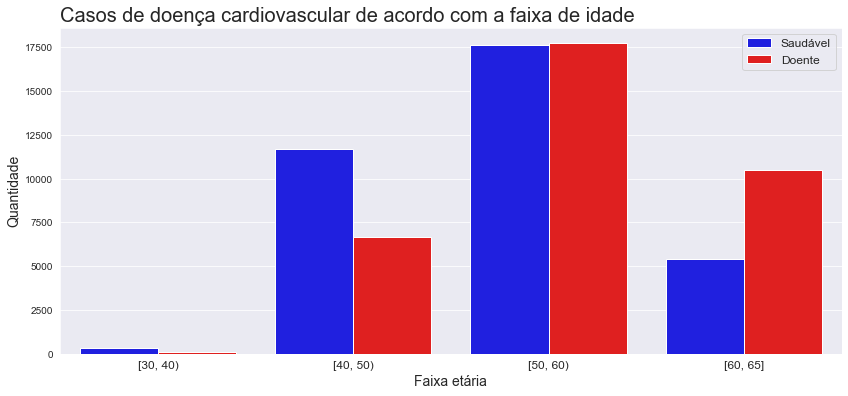

In [30]:
plt.figure(figsize = (14, 6))
idade = sns.countplot(x = 'cat_age', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                       order = ['[30, 40)', '[40, 50)', '[50, 60)', '[60, 65]'])
idade.set_title("Casos de doença cardiovascular de acordo com a faixa de idade", fontsize = 20, loc = 'left')
idade.set_xlabel("Faixa etária", fontsize = 14)
idade.set_ylabel("Quantidade", fontsize = 14)
idade.legend(['Saudável', 'Doente'], fontsize = 12)
idade.set_xticklabels(['[30, 40)', '[40, 50)', '[50, 60)', '[60, 65]'], fontsize = 12)
idade = idade

O risco de doença cardiovascular aumenta de acordo com a faixa etária, sendo muito mais incidênte após os 60 anos de idade.

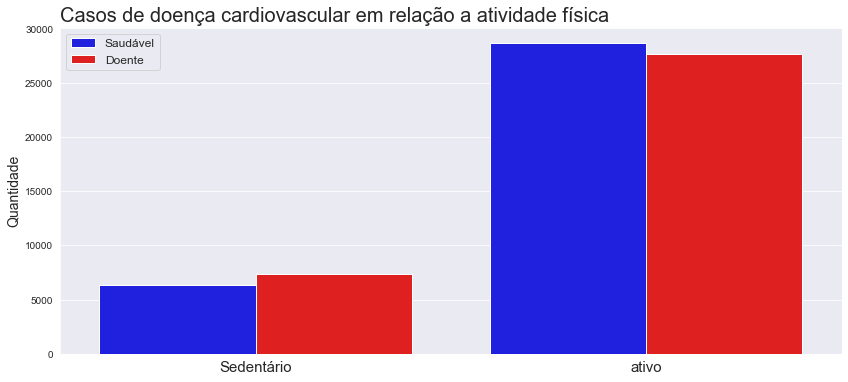

In [31]:
plt.figure(figsize = (14, 6))
ativ = sns.countplot(x = 'active', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
ativ.set_title("Casos de doença cardiovascular em relação a atividade física", fontsize = 20, loc = 'left')
ativ.set_xlabel("")
ativ.set_ylabel("Quantidade", fontsize = 14)
ativ.legend(['Saudável', 'Doente'], fontsize = 12)
ativ.set_xticklabels(['Sedentário', 'ativo'], fontsize = 15)
ativ = ativ

Atividade física parece influenciar muito pouco na proporção de incidência de doença cardiovascular.

## Preparando o modelo de classificação

Pela análise visual vimos que as variáveis que mais influênciam na proporção de incidência de doença cardiovascular são:
- Colesterol (cholesterol)
- Glicose (gluc)
- Pressão arterial sistólica (cat_aphi)
- Pressão arterial diastólica (cat_aplo)
- Índice de massa corporal (cat_imc)
- Faixa de idade (cat_age)

Vamos usar essas variáveis no classificador.

In [32]:
np.random.seed(301)

In [33]:
data_to_predict.head(1)

,gender,cholesterol,gluc,smoke,alco,cat_aphi,cat_aplo,cat_imc,cat_age,active,cardio
0,H,1,1,0,0,normal,normal,normal,"[50, 60)",1,0


In [34]:
x = data_to_predict[['cholesterol', 'gluc', 'cat_aphi', 'cat_aplo', 'cat_imc', 'cat_age']]
y = data_to_predict['cardio']

In [35]:
variaveis = ['cat_aphi', 'cat_aplo', 'cat_imc', 'cat_age']
encode = LabelEncoder()

for i  in variaveis:
    x[i] = encode.fit_transform(x[i])

In [38]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, stratify = y)
print(f'Dimensão da base de treino: {xtrain.shape}\nDimensão da base de teste: {xtest.shape}')

Dimensão da base de treino: (52500, 6)
Dimensão da base de teste: (17500, 6)


#### DecisionTreeClassifier

In [56]:
for i in range(2, 21): 
    dtc = DecisionTreeClassifier(max_depth = i)

    dtc.fit(xtrain, ytrain)
    prev_dtc = dtc.predict(xtest)
    print(i, round(accuracy_score(ytest, prev_dtc)*100, 2))
    

2 71.47
3 71.44
4 72.77
5 72.98
6 72.92
7 73.2
8 73.24
9 73.12
10 73.12
11 73.0
12 72.98
13 72.79
14 72.82
15 72.81
16 72.81
17 72.81
18 72.81
19 72.81
20 72.81


O melhor resultado foi a arvore de decisão com profundidade igual a 8. Vamos fazer uma validação cruzada.

In [57]:
def imprime_resultados(results):
    media = results['test_score'].mean()
    desvio_padrao = results['test_score'].std()
    print("Accuracy médio: %.2f" % (media * 100))
    print("Accuracy intervalo: [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

In [62]:
cv = KFold(n_splits = 10, shuffle=True)
dtc = DecisionTreeClassifier(max_depth = 8)
results = cross_validate(dtc, x, y, cv = cv, return_train_score=False)
imprime_resultados(results)

Accuracy médio: 72.91
Accuracy intervalo: [72.18, 73.63]


O resultado médio do nosso modelo foi de 72.91% podendo variar no intervalo [72.18%, 73.63%]

#### - Random Forest Classifier

In [68]:
for i in range(2, 21):
    rfc = RandomForestClassifier(max_depth = i)
    rfc.fit(xtrain, ytrain)
    prev_rfc = rfc.predict(xtest)
    print(i, round(accuracy_score(ytest, prev_rfc)*100, 2))

2 72.38
3 72.68
4 73.13
5 73.12
6 73.17
7 73.12
8 73.17
9 73.31
10 73.24
11 73.11
12 73.12
13 73.14
14 73.09
15 72.96
16 72.97
17 72.92
18 72.94
19 72.94
20 73.08


Desta vez o melhor resultado foi com profundidade máxima igual a 9. Vamos novamente fazer uma validação cruzada.

In [69]:
cv = KFold(n_splits = 10, shuffle=True)
rfc = RandomForestClassifier(max_depth = 9)
results = cross_validate(rfc, x, y, cv = cv, return_train_score=False)
imprime_resultados(results)

Accuracy médio: 72.98
Accuracy intervalo: [71.56, 74.40]


A melhora no resultado foi quaase nula com acurácia de 72.98%, porém o intervalo de erro foi maior também [71.56%, 74.40%]

#### - ExtraTreesClassifier

In [72]:
for i in range(2, 21):
    etc = ExtraTreesClassifier(max_depth = i)
    etc.fit(xtrain, ytrain)
    prev_etc = etc.predict(xtest)
    print(i, round(accuracy_score(ytest, prev_etc)*100, 2))

2 72.19
3 72.19
4 72.36
5 72.81
6 72.61
7 73.07
8 73.15
9 73.14
10 73.12
11 73.22
12 73.03
13 73.14
14 73.02
15 72.97
16 72.9
17 72.88
18 72.88
19 72.86
20 72.87


Aqui o melhor resultado obtido foi com profundidade máxima igual a 11. Vamos validar.

In [73]:
cv = KFold(n_splits = 10, shuffle=True)
etc = ExtraTreesClassifier(max_depth = 11)
results = cross_validate(etc, x, y, cv = cv, return_train_score=False)
imprime_resultados(results)

Accuracy médio: 72.86
Accuracy intervalo: [72.14, 73.57]


Aqui o resultado piorou muito pouco. 

O melhor resultado obtido foi utilizando o Random Frorest Classifier, nele obtivemos 72.98% de acurácia, com intervalo de erro de [71.56%, 74.40%].